In [57]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from pathlib import Path
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import math
from scipy.stats import entropy
import json

# Import the position_dependent_gaussian module
from position_dependent_gaussian import (
    sample_position_dependent_gaussian,
    render_sparse_frames,
    render_gaussian_frames,
    generate_dataset,
    DEFAULT_CONFIG
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
IMAGE_SIZE = 32
SEQUENCE_LENGTH = 20
GRID_SIZE = 10  # Increased from 8 to 10 for better resolution
ORIENTATION_TYPES = ['center_directed', 'boundary_tangent', 'random']
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 100

# Output directories
OUTPUT_DIR = Path("../data/position_dependent_gaussian")
VISUALIZATION_DIR = Path("../data/visualizations")

# Ensure directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

# Configure plot style for better appearance
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.axisbelow'] = True  # Grid below plots

print("Setup complete.")


Setup complete.


In [58]:
def load_or_generate_datasets(orientation_type, force_generate=False):
    """Load existing datasets or generate new ones with the specified orientation type."""
    
    # Check if datasets already exist
    train_sparse_path = OUTPUT_DIR / f"train_sparse_data.pt"
    train_gaussian_path = OUTPUT_DIR / f"train_gaussian_data.pt"
    val_sparse_path = OUTPUT_DIR / f"val_sparse_data.pt"
    val_gaussian_path = OUTPUT_DIR / f"val_gaussian_data.pt"
    test_sparse_path = OUTPUT_DIR / f"test_sparse_data.pt"
    test_gaussian_path = OUTPUT_DIR / f"test_gaussian_data.pt"
    
    all_paths_exist = all(p.exists() for p in [
        train_sparse_path, train_gaussian_path,
        val_sparse_path, val_gaussian_path,
        test_sparse_path, test_gaussian_path
    ])
    
    if all_paths_exist and not force_generate:
        print(f"Loading existing datasets...")
        train_data_sparse = torch.load(train_sparse_path)
        train_data_gaussian = torch.load(train_gaussian_path)
        val_data_sparse = torch.load(val_sparse_path)
        val_data_gaussian = torch.load(val_gaussian_path)
        test_data_sparse = torch.load(test_sparse_path)
        test_data_gaussian = torch.load(test_gaussian_path)
    else:
        print(f"Generating datasets with orientation type {orientation_type}...")
        # Update config with orientation type
        config = DEFAULT_CONFIG.copy()
        config['orientation_type'] = orientation_type
        
        # Generate datasets
        train_data_sparse = generate_dataset(TRAIN_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                      config=config, representation='sparse')
        train_data_gaussian = generate_dataset(TRAIN_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                        config=config, representation='gaussian')
        
        val_data_sparse = generate_dataset(VAL_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                    config=config, representation='sparse')
        val_data_gaussian = generate_dataset(VAL_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                      config=config, representation='gaussian')
        
        test_data_sparse = generate_dataset(TEST_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                     config=config, representation='sparse')
        test_data_gaussian = generate_dataset(TEST_SIZE, SEQUENCE_LENGTH, IMAGE_SIZE, 
                                       config=config, representation='gaussian')
        
        # Save datasets
        torch.save(train_data_sparse, train_sparse_path)
        torch.save(train_data_gaussian, train_gaussian_path)
        torch.save(val_data_sparse, val_sparse_path)
        torch.save(val_data_gaussian, val_gaussian_path)
        torch.save(test_data_sparse, test_sparse_path)
        torch.save(test_data_gaussian, test_gaussian_path)
        
        # Save configuration
        with open(OUTPUT_DIR / "config.json", "w") as f:
            config_dict = {k: v if not isinstance(v, tuple) else list(v) 
                           for k, v in config.items()}
            json.dump(config_dict, f, indent=4)
    
    return {
        'train': {'sparse': train_data_sparse, 'gaussian': train_data_gaussian},
        'val': {'sparse': val_data_sparse, 'gaussian': val_data_gaussian},
        'test': {'sparse': test_data_sparse, 'gaussian': test_data_gaussian}
    }

# Choose which orientation type to visualize
orientation_type = 'center_directed'  # Options: 'center_directed', 'boundary_tangent', 'random'
print(f"Visualizing {orientation_type} orientation type")

# Load or generate dataset
datasets = load_or_generate_datasets(orientation_type)

# Print dataset shapes
for split in ['train', 'val', 'test']:
    for rep in ['sparse', 'gaussian']:
        frames = datasets[split][rep]['frames']
        coords = datasets[split][rep]['coordinates']
        print(f"  {split} {rep}: frames={frames.shape}, coordinates={coords.shape}")


Visualizing center_directed orientation type
Generating datasets with orientation type center_directed...
  train sparse: frames=torch.Size([1000, 20, 1, 32, 32]), coordinates=torch.Size([1000, 20, 2])
  train gaussian: frames=torch.Size([1000, 20, 1, 32, 32]), coordinates=torch.Size([1000, 20, 2])
  val sparse: frames=torch.Size([100, 20, 1, 32, 32]), coordinates=torch.Size([100, 20, 2])
  val gaussian: frames=torch.Size([100, 20, 1, 32, 32]), coordinates=torch.Size([100, 20, 2])
  test sparse: frames=torch.Size([100, 20, 1, 32, 32]), coordinates=torch.Size([100, 20, 2])
  test gaussian: frames=torch.Size([100, 20, 1, 32, 32]), coordinates=torch.Size([100, 20, 2])


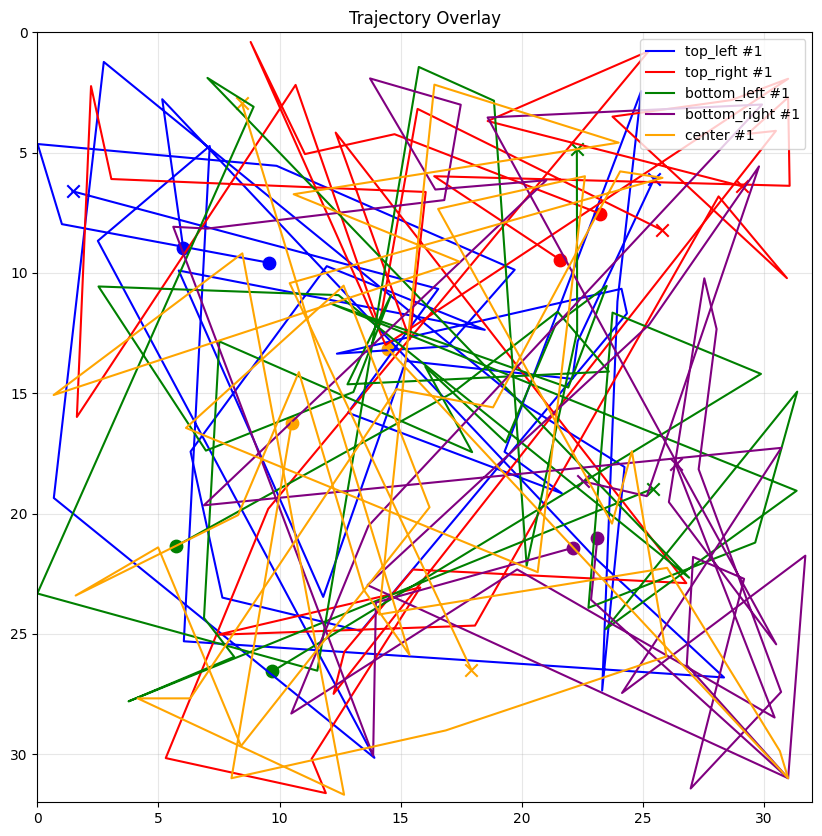

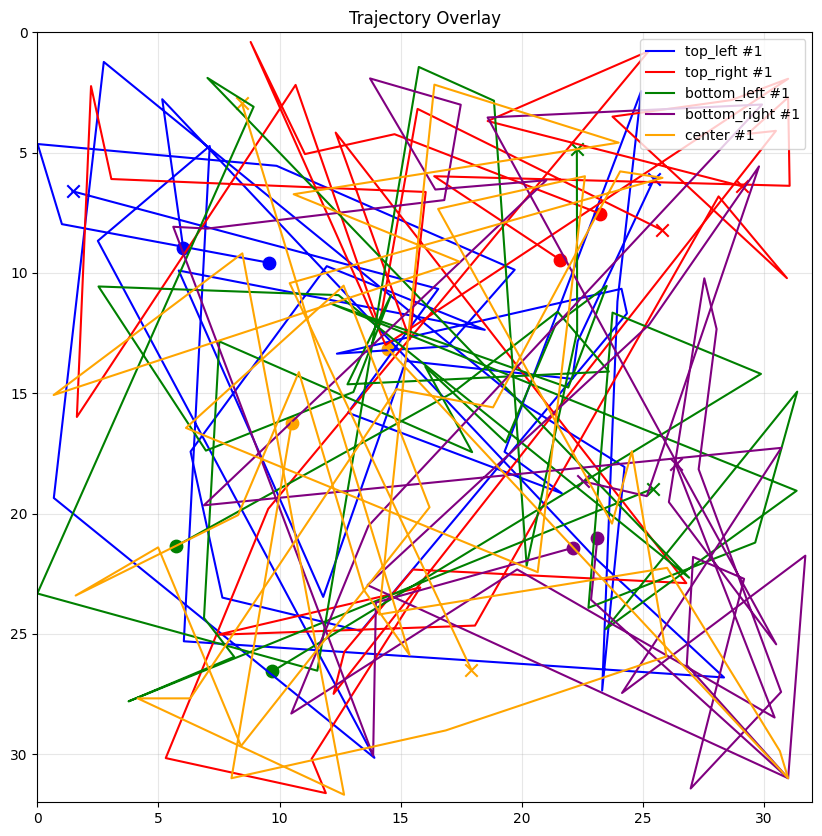

In [59]:
def visualize_trajectory_overlay(datasets):
    """Visualize trajectory overlays by region, limited to 2 per region."""
    
    # Define regions and colors
    regions = {
        'top_left': [(0, IMAGE_SIZE//3), (0, IMAGE_SIZE//3)],
        'top_right': [(0, IMAGE_SIZE//3), (2*IMAGE_SIZE//3, IMAGE_SIZE)],
        'bottom_left': [(2*IMAGE_SIZE//3, IMAGE_SIZE), (0, IMAGE_SIZE//3)],
        'bottom_right': [(2*IMAGE_SIZE//3, IMAGE_SIZE), (2*IMAGE_SIZE//3, IMAGE_SIZE)],
        'center': [(IMAGE_SIZE//3, 2*IMAGE_SIZE//3), (IMAGE_SIZE//3, 2*IMAGE_SIZE//3)]
    }
    
    colors = {
        'top_left': 'blue',
        'top_right': 'red',
        'bottom_left': 'green',
        'bottom_right': 'purple',
        'center': 'orange'
    }
    
    # Create visualization showing only 2 trajectories per region
    plt.figure(figsize=(10, 10))
    plt.title(f"Trajectory Overlay")
    plt.xlim(0, IMAGE_SIZE)
    plt.ylim(0, IMAGE_SIZE)
    
    # Get trajectories from the training data
    all_coords = datasets['train']['gaussian']['coordinates']
    
    for region_name, (y_range, x_range) in regions.items():
        # Filter trajectories that start in this region
        region_trajectories = []
        for i in range(all_coords.shape[0]):
            y, x = all_coords[i, 0]  # Starting position
            if (y_range[0] <= y < y_range[1] and x_range[0] <= x < x_range[1]):
                region_trajectories.append((i, all_coords[i]))
        
        # Plot exactly 2 trajectories if available
        count = 0
        for idx, traj in region_trajectories:
            if count >= 2:  # Limit to 2 trajectories per region
                break
                
            y = traj[:, 0].numpy()
            x = traj[:, 1].numpy()
            
            # Plot the trajectory line
            plt.plot(x, y, '-', color=colors[region_name], linewidth=1.5, 
                    label=f"{region_name} #{count+1}" if count == 0 else None)
            
            # Plot start and end points
            plt.scatter(x[0], y[0], color=colors[region_name], s=80, marker='o')
            plt.scatter(x[-1], y[-1], color=colors[region_name], s=80, marker='x')
            
            count += 1
    
    plt.gca().invert_yaxis()  # Image coordinate system has y=0 at top
    plt.legend(loc='upper right')
    
    # Save visualization
    os.makedirs(VISUALIZATION_DIR, exist_ok=True)
    plt.savefig(VISUALIZATION_DIR / f"trajectory_overlay.png", dpi=300, bbox_inches='tight')
    
    return plt.gcf()

# Create trajectory overlay visualization
visualize_trajectory_overlay(datasets)


Displacement statistics:
  Mean: 10.66
  Median: 9.37
  25th percentile: 5.44
  75th percentile: 14.55
  Min: 0.00
  Max: 42.56


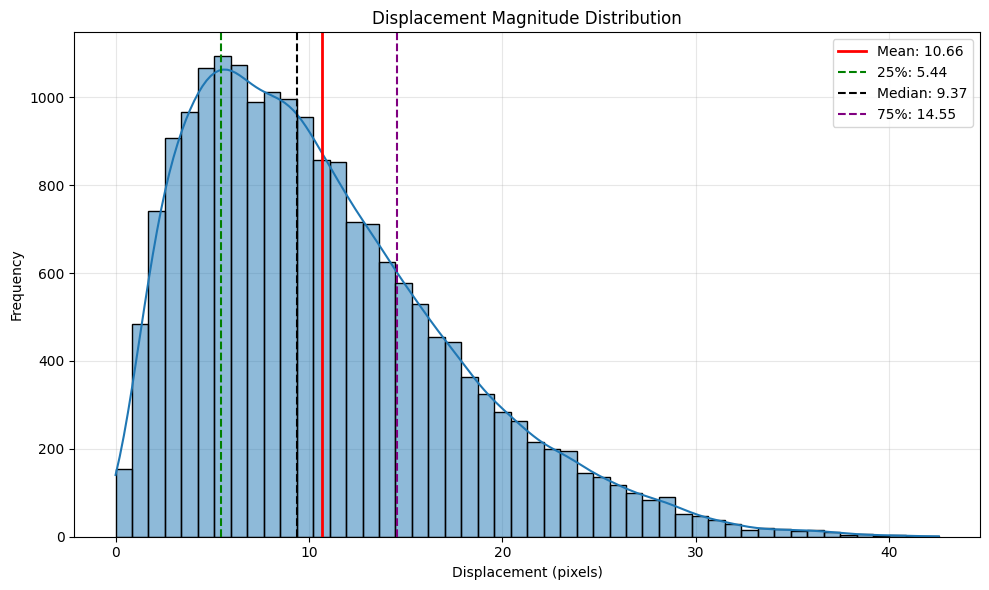

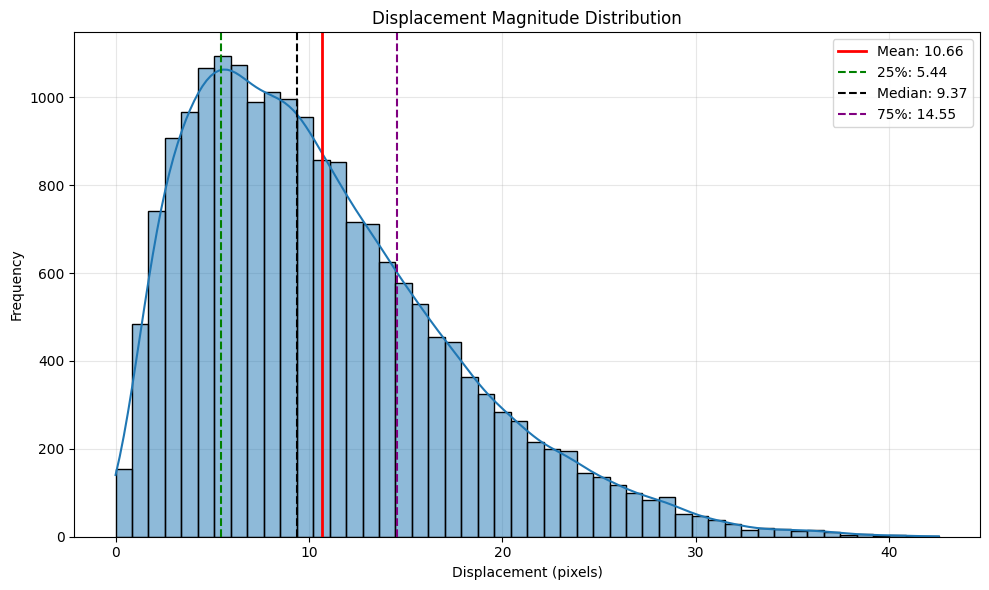

In [60]:
def visualize_displacement_histogram(datasets):
    """Create histogram of displacement magnitudes."""
    
    # Extract displacements from trajectories
    all_coords = datasets['train']['gaussian']['coordinates']
    displacements = []
    
    for i in range(all_coords.shape[0]):
        for t in range(1, all_coords.shape[1]):
            prev_pos = all_coords[i, t-1]
            curr_pos = all_coords[i, t]
            displacement = torch.sqrt(torch.sum((curr_pos - prev_pos)**2)).item()
            displacements.append(displacement)
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(displacements, kde=True, bins=50)
    plt.title("Displacement Magnitude Distribution")
    plt.xlabel("Displacement (pixels)")
    plt.ylabel("Frequency")
    
    # Add vertical lines for mean and quantiles
    q25, q50, q75 = np.quantile(displacements, [0.25, 0.5, 0.75])
    mean_disp = np.mean(displacements)
    
    plt.axvline(x=float(mean_disp), color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_disp:.2f}')
    plt.axvline(x=float(q25), color='green', linestyle='--', linewidth=1.5, label=f'25%: {q25:.2f}')
    plt.axvline(x=float(q50), color='black', linestyle='--', linewidth=1.5, label=f'Median: {q50:.2f}')
    plt.axvline(x=float(q75), color='purple', linestyle='--', linewidth=1.5, label=f'75%: {q75:.2f}')
    
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(VISUALIZATION_DIR / "displacement_histogram.png", dpi=300, bbox_inches='tight')
    
    # Print statistics
    print(f"Displacement statistics:")
    print(f"  Mean: {mean_disp:.2f}")
    print(f"  Median: {q50:.2f}")
    print(f"  25th percentile: {q25:.2f}")
    print(f"  75th percentile: {q75:.2f}")
    print(f"  Min: {min(displacements):.2f}")
    print(f"  Max: {max(displacements):.2f}")
    
    return plt.gcf()

# Create displacement histogram
visualize_displacement_histogram(datasets)


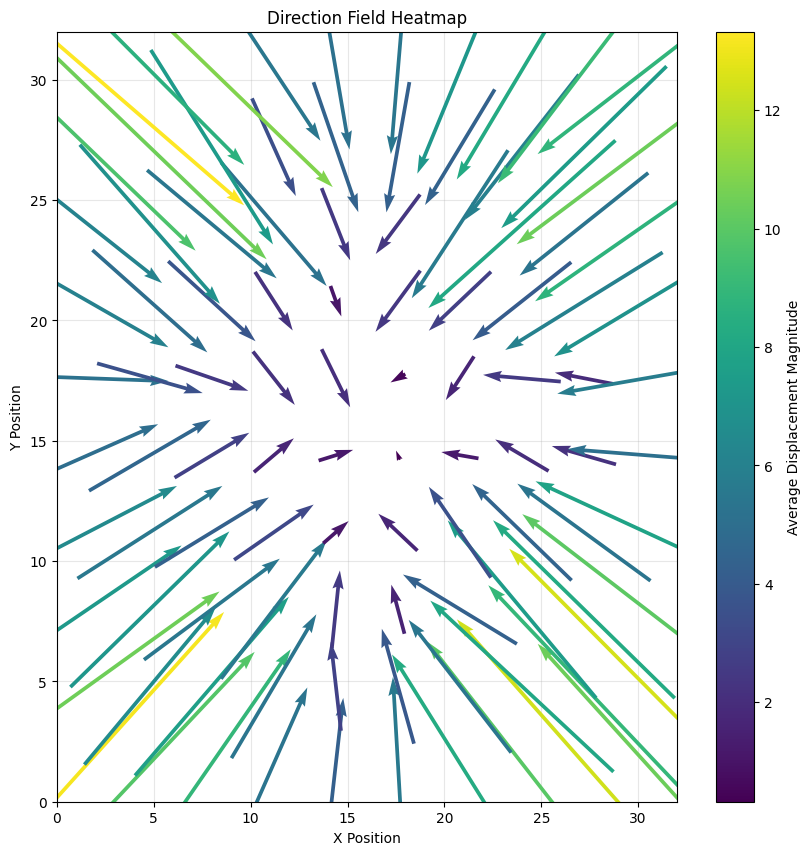

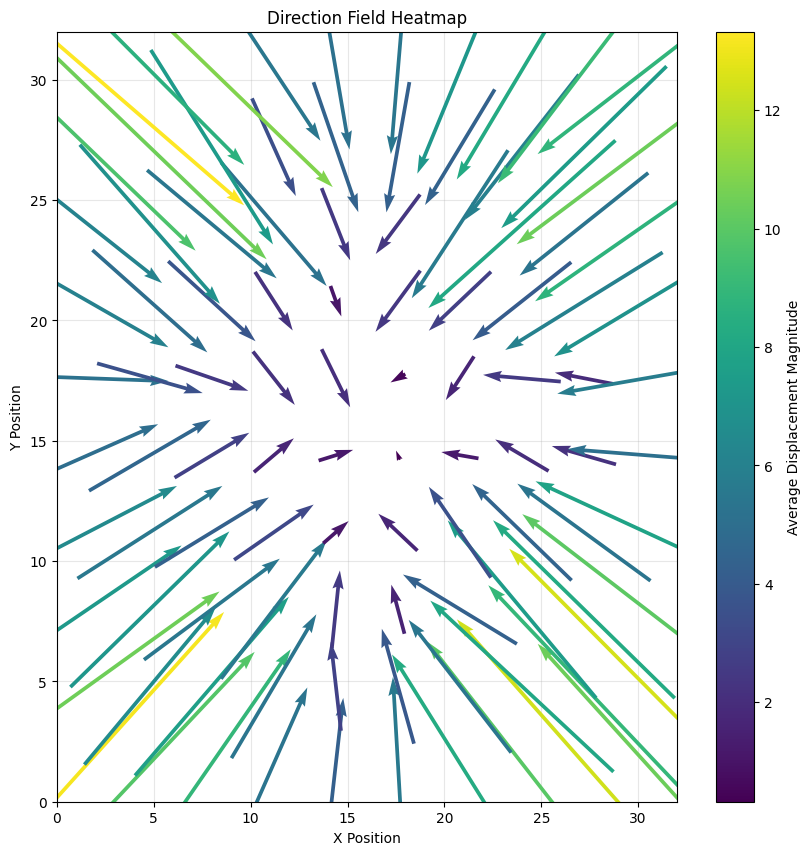

In [68]:
def visualize_direction_field(datasets):
    """Create direction field visualization showing average movement direction at each grid point."""
    
    # Get coordinates from the training data
    all_coords = datasets['train']['gaussian']['coordinates']
    
    # Initialize direction vectors
    direction_x = np.zeros((GRID_SIZE, GRID_SIZE))
    direction_y = np.zeros((GRID_SIZE, GRID_SIZE))
    counts = np.zeros((GRID_SIZE, GRID_SIZE))
    
    # Calculate cell size
    cell_size = IMAGE_SIZE / GRID_SIZE
    
    # Extract direction vectors from trajectories
    for i in range(all_coords.shape[0]):
        for t in range(1, all_coords.shape[1]):
            prev_pos = all_coords[i, t-1]
            curr_pos = all_coords[i, t]
            
            # Calculate direction vector
            dy = curr_pos[0] - prev_pos[0]
            dx = curr_pos[1] - prev_pos[1]
            
            # Determine grid cell of previous position
            grid_y = min(int(prev_pos[0].item() / cell_size), GRID_SIZE - 1)
            grid_x = min(int(prev_pos[1].item() / cell_size), GRID_SIZE - 1)
            
            # Accumulate direction vectors
            direction_y[grid_y, grid_x] += dy.item()
            direction_x[grid_y, grid_x] += dx.item()
            counts[grid_y, grid_x] += 1
    
    # Normalize direction vectors
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            if counts[y, x] > 0:
                direction_y[y, x] /= counts[y, x]
                direction_x[y, x] /= counts[y, x]
    
    # Calculate magnitudes for coloring
    magnitudes = np.sqrt(direction_x**2 + direction_y**2)
    
    # Create direction field visualization
    plt.figure(figsize=(10, 10))
    
    # Create meshgrid for quiver
    y_centers = np.linspace(cell_size/2, IMAGE_SIZE - cell_size/2, GRID_SIZE)
    x_centers = np.linspace(cell_size/2, IMAGE_SIZE - cell_size/2, GRID_SIZE)
    X, Y = np.meshgrid(x_centers, y_centers)
    
    # Plot direction field
    plt.quiver(X, Y, direction_x, direction_y, magnitudes, cmap='viridis', 
               pivot='mid', scale=20, width=0.006)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Average Displacement Magnitude')
    
    plt.title("Direction Field Heatmap")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(0, IMAGE_SIZE)
    plt.ylim(0, IMAGE_SIZE)
    
    
    # Save figure
    plt.savefig(VISUALIZATION_DIR / "direction_field_heatmap.png", dpi=300, bbox_inches='tight')
    
    return plt.gcf()

# Create direction field visualization
visualize_direction_field(datasets)


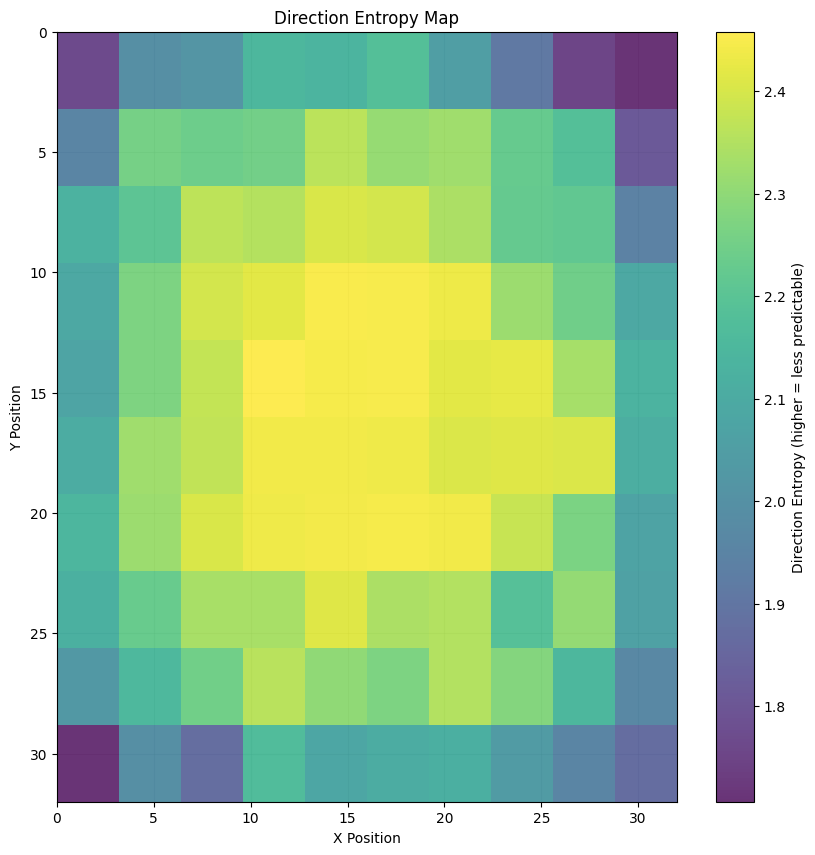

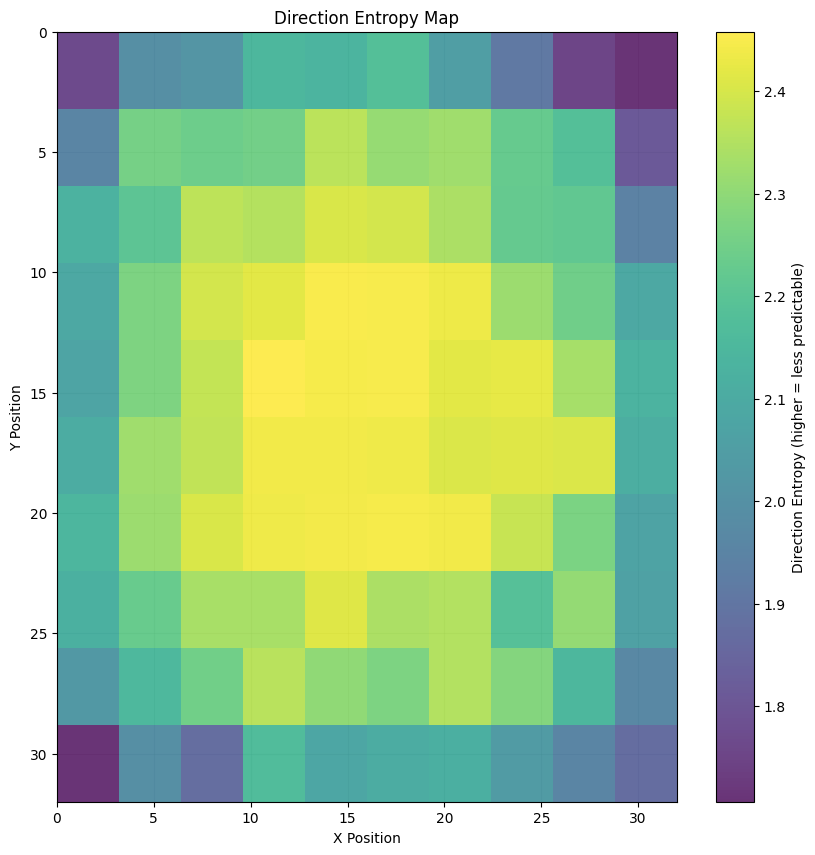

In [62]:
def visualize_direction_entropy(datasets):
    """Create entropy map showing predictability of direction at each grid point."""
    
    # Get coordinates from the training data
    all_coords = datasets['train']['gaussian']['coordinates']
    
    # Calculate cell size
    cell_size = IMAGE_SIZE / GRID_SIZE
    angle_bins = 12  # Number of bins for discretizing angles
    
    # Initialize angle histograms for each grid cell
    angle_histograms = np.zeros((GRID_SIZE, GRID_SIZE, angle_bins))
    
    # Extract angles from trajectories
    for i in range(all_coords.shape[0]):
        for t in range(1, all_coords.shape[1]):
            prev_pos = all_coords[i, t-1]
            curr_pos = all_coords[i, t]
            
            # Calculate direction vector
            dy = curr_pos[0] - prev_pos[0]
            dx = curr_pos[1] - prev_pos[1]
            
            # Calculate angle in degrees
            angle = math.degrees(math.atan2(dy.item(), dx.item())) % 360
            angle_bin = int(angle / (360 / angle_bins))
            
            # Determine grid cell of previous position
            grid_y = min(int(prev_pos[0].item() / cell_size), GRID_SIZE - 1)
            grid_x = min(int(prev_pos[1].item() / cell_size), GRID_SIZE - 1)
            
            # Update angle histogram
            angle_histograms[grid_y, grid_x, angle_bin] += 1
    
    # Calculate entropy for each grid cell
    entropies = np.zeros((GRID_SIZE, GRID_SIZE))
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            hist = angle_histograms[y, x]
            # Only calculate entropy if we have data
            if np.sum(hist) > 0:
                # Normalize histogram
                hist = hist / np.sum(hist)
                entropies[y, x] = entropy(hist)
    
    # Create entropy map visualization
    plt.figure(figsize=(10, 10))
    
    # Create meshgrid for plotting
    y_edges = np.linspace(0, IMAGE_SIZE, GRID_SIZE + 1)
    x_edges = np.linspace(0, IMAGE_SIZE, GRID_SIZE + 1)
    
    # Plot entropy heatmap
    plt.pcolormesh(x_edges, y_edges, entropies, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Direction Entropy (higher = less predictable)')
    
    plt.title("Direction Entropy Map")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(0, IMAGE_SIZE)
    plt.ylim(0, IMAGE_SIZE)
    plt.gca().invert_yaxis()  # Image coordinate system has y=0 at top
    
    # Save figure
    plt.savefig(VISUALIZATION_DIR / "direction_entropy_map.png", dpi=300, bbox_inches='tight')
    
    return plt.gcf()

# Create direction entropy visualization
visualize_direction_entropy(datasets)


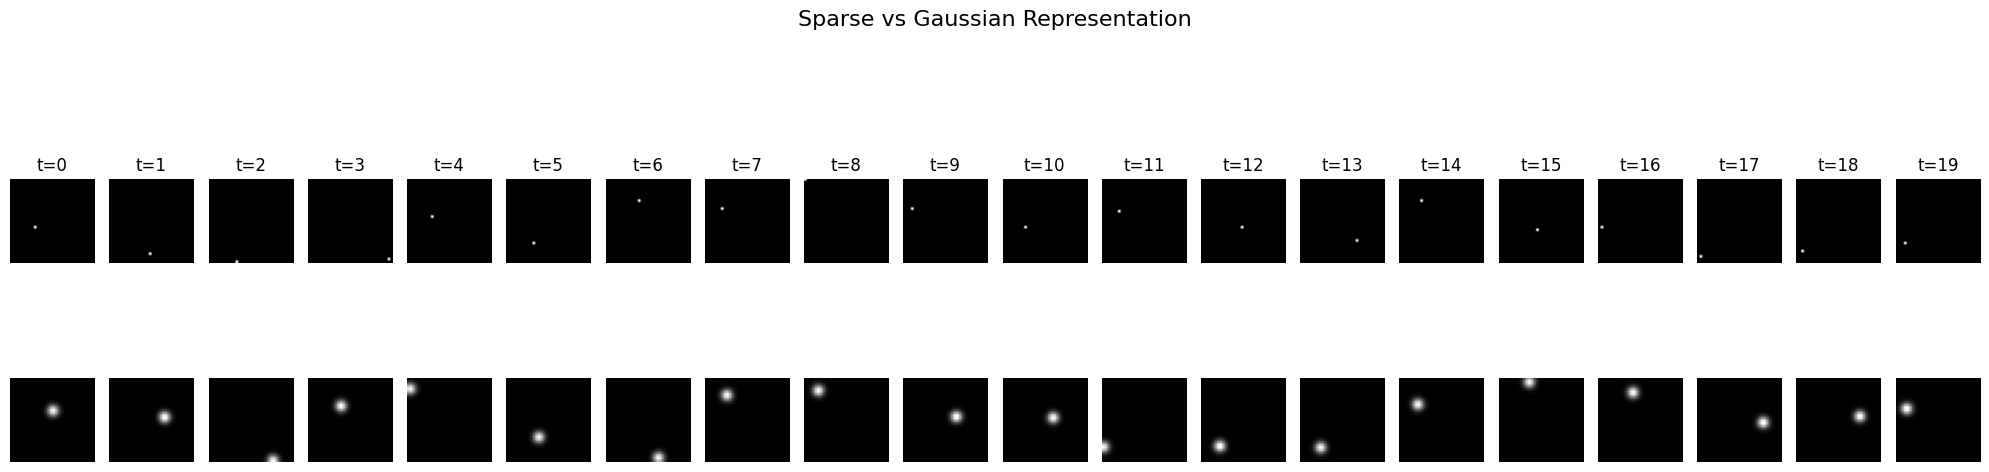

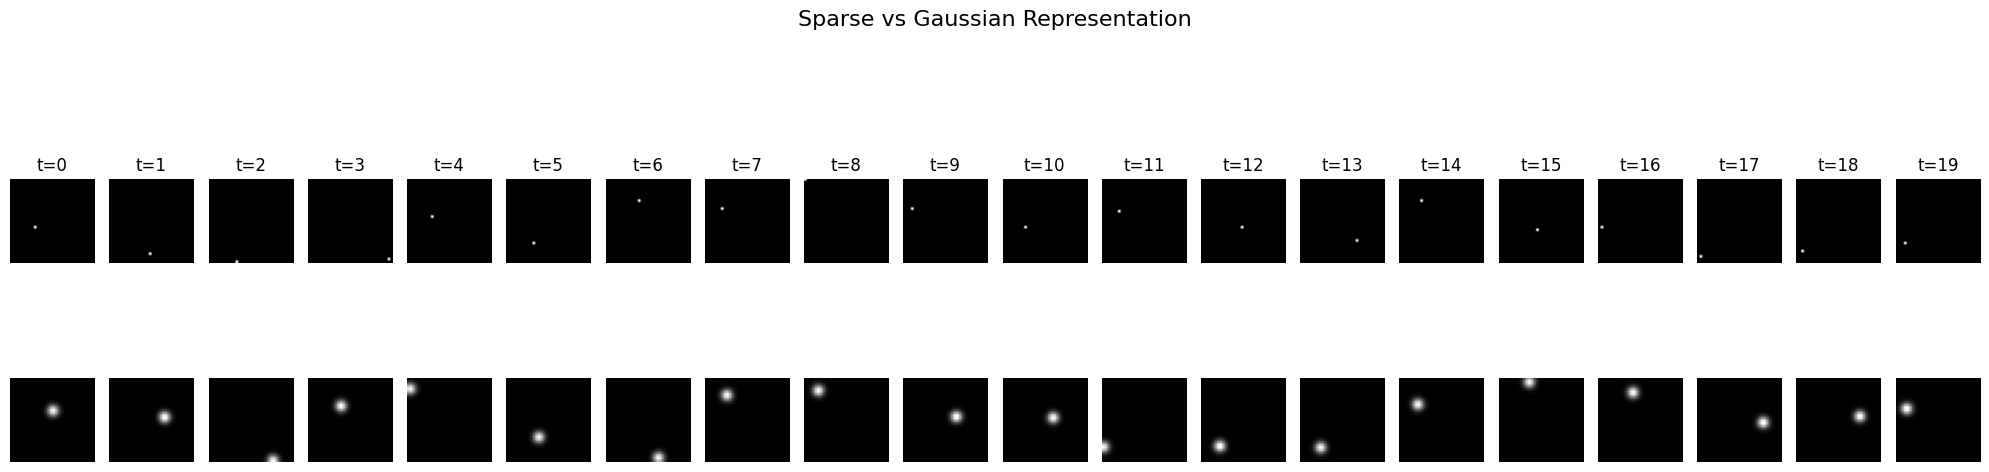

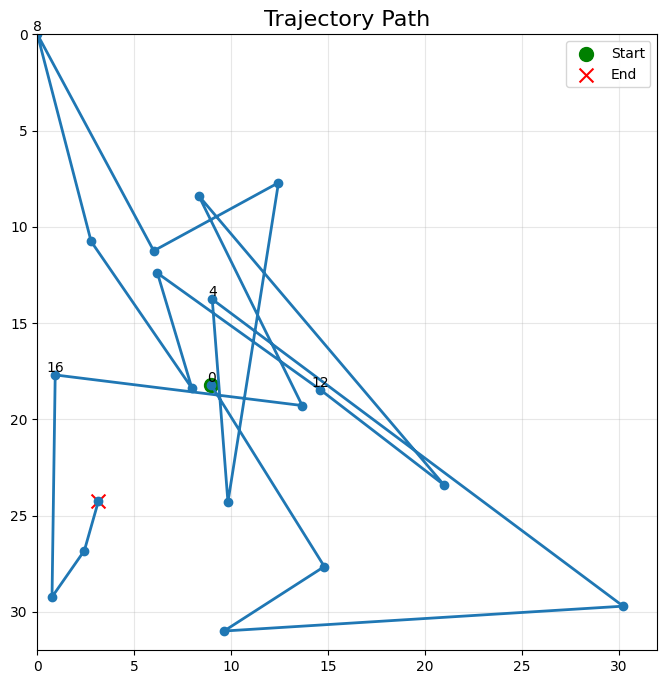

In [66]:
def compare_representations(datasets, sample_idx=1):
    """Compare sparse and Gaussian frame representations of the same trajectory."""
    
    # Get frames and coordinates
    sparse_frames = datasets['test']['sparse']['frames']
    gaussian_frames = datasets['test']['gaussian']['frames']
    coordinates = datasets['test']['sparse']['coordinates']
    
    # Create figure for this sample
    fig, axes = plt.subplots(2, SEQUENCE_LENGTH, figsize=(20, 6))
    fig.suptitle("Sparse vs Gaussian Representation", fontsize=16)
    
    # Plot sparse frames
    for t in range(SEQUENCE_LENGTH):
        axes[0, t].imshow(sparse_frames[sample_idx, t, 0].numpy(), cmap='gray')
        axes[0, t].set_title(f"t={t}")
        axes[0, t].axis('off')
    
    # Plot Gaussian frames
    for t in range(SEQUENCE_LENGTH):
        axes[1, t].imshow(gaussian_frames[sample_idx, t, 0].numpy(), cmap='gray')
        axes[1, t].axis('off')
    
    # Add row labels
    axes[0, 0].set_ylabel("Sparse", fontsize=14)
    axes[1, 0].set_ylabel("Gaussian", fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save figure
    plt.savefig(VISUALIZATION_DIR / "representation_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot the trajectory
    plt.figure(figsize=(8, 8))
    plt.title("Trajectory Path", fontsize=16)
    
    traj = coordinates[sample_idx].numpy()
    plt.plot(traj[:, 1], traj[:, 0], '-o', linewidth=2, markersize=6)
    
    # Add start and end markers
    plt.scatter(traj[0, 1], traj[0, 0], color='green', s=100, marker='o', label="Start")
    plt.scatter(traj[-1, 1], traj[-1, 0], color='red', s=100, marker='x', label="End")
    
    # Add frame numbers
    for t in range(0, SEQUENCE_LENGTH, 4):  # Add labels every 4 frames
        plt.annotate(f"{t}", (traj[t, 1], traj[t, 0]), 
                    fontsize=10, ha='center', va='bottom')
    
    plt.xlim(0, IMAGE_SIZE)
    plt.ylim(0, IMAGE_SIZE)
    plt.gca().invert_yaxis()  # Image coordinate system has y=0 at top
    plt.legend()
    
    plt.savefig(VISUALIZATION_DIR / "trajectory_path.png", dpi=300, bbox_inches='tight')
    
    return fig

# Compare representations
compare_representations(datasets)


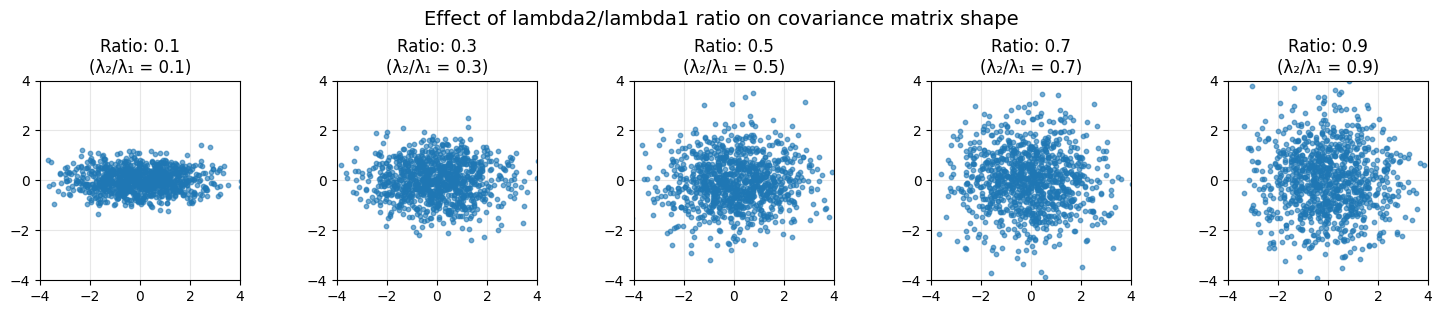

Lambda ratio explanation:
- Ratio closer to 1.0 = more circular distribution
- Ratio closer to 0.0 = more elliptical distribution
- Current settings: short steps (0.4), long steps (0.3)


In [ ]:
from position_dependent_gaussian import build_cov_matrix

def visualize_covariance_ellipses():
    """Visualize how different lambda ratios affect the shape of the covariance matrix."""
    
    # Test different lambda ratios
    lambda_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    theta = 0  # No rotation for simplicity
    lambda1 = 2.0  # Fixed major axis
    
    fig, axes = plt.subplots(1, len(lambda_ratios), figsize=(15, 3))
    fig.suptitle('Effect of lambda2/lambda1 ratio on covariance matrix shape', fontsize=14)
    
    for i, ratio in enumerate(lambda_ratios):
        lambda2 = lambda1 * ratio
        cov_matrix = build_cov_matrix(theta, lambda1, lambda2)
        
        # Generate points from this distribution
        n_points = 1000
        points = torch.distributions.MultivariateNormal(
            torch.zeros(2), cov_matrix
        ).sample((n_points,))
        
        # Plot the points
        axes[i].scatter(points[:, 0], points[:, 1], alpha=0.6, s=10)
        axes[i].set_title(f'Ratio: {ratio:.1f}\n(λ₂/λ₁ = {ratio})')
        axes[i].set_xlim(-4, 4)
        axes[i].set_ylim(-4, 4)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('lambda_ratio_demo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Lambda ratio explanation:")
    print("- Ratio closer to 1.0 = more circular distribution")
    print("- Ratio closer to 0.0 = more elliptical distribution")
    print("- Current settings: short steps (0.4), long steps (0.2)")

visualize_covariance_ellipses()